In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

FileNotFoundError: [Errno 2] No such file or directory: 'data/FremontBridge.csv'

In [7]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

NameError: name 'counts' is not defined

In [8]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

NameError: name 'daily' is not defined

In [9]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

NameError: name 'daily' is not defined

In [10]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

NameError: name 'weather' is not defined

In [11]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

daily.head()

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params


import matplotlib.pyplot as plt
daily[:5]
daily.corr(method='spearman')

NameError: name 'daily' is not defined

This is where our HW Code begins

In [1]:
# Define feature columns and target
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# Initialize models
linear_model = LinearRegression()
lasso_model = make_pipeline(StandardScaler(), Lasso())
ridge_model = make_pipeline(StandardScaler(), Ridge())

NameError: name 'daily' is not defined

In [2]:
# Set up parameter grid for RandomizedSearchCV
lasso_param_grid = {'lasso__alpha': np.logspace(-3, 3, 7)}
ridge_param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}

# RandomizedSearchCV for Lasso
lasso_search = RandomizedSearchCV(lasso_model, lasso_param_grid, n_iter=10, cv=10, random_state=42)
lasso_search.fit(X, y)
lasso_cv_scores = cross_val_score(lasso_search.best_estimator_, X, y, cv=10)

# RandomizedSearchCV for Ridge
ridge_search = RandomizedSearchCV(ridge_model, ridge_param_grid, n_iter=10, cv=10, random_state=42)
ridge_search.fit(X, y)
ridge_cv_scores = cross_val_score(ridge_search.best_estimator_, X, y, cv=10)

NameError: name 'np' is not defined

In [3]:
# Evaluate Linear Regression with 10-fold CV
linear_cv_scores = cross_val_score(linear_model, X, y, cv=10)

# Collect results
results = {
    'Model': ['Linear Regression', 'Lasso', 'Ridge'],
    'Mean CV Score': [linear_cv_scores.mean(), lasso_cv_scores.mean(), ridge_cv_scores.mean()],
    'Best Alpha (if applied)': [None, lasso_search.best_params_['lasso__alpha'], ridge_search.best_params_['ridge__alpha']]
}

results_df = pd.DataFrame(results)

NameError: name 'cross_val_score' is not defined

In [4]:
# Display results
print(results_df)

# Determine the best model
best_model = results_df.loc[results_df['Mean CV Score'].idxmax()]
print(f"Best Model: {best_model['Model']} with a score of {best_model['Mean CV Score']:.2f}")

NameError: name 'results_df' is not defined

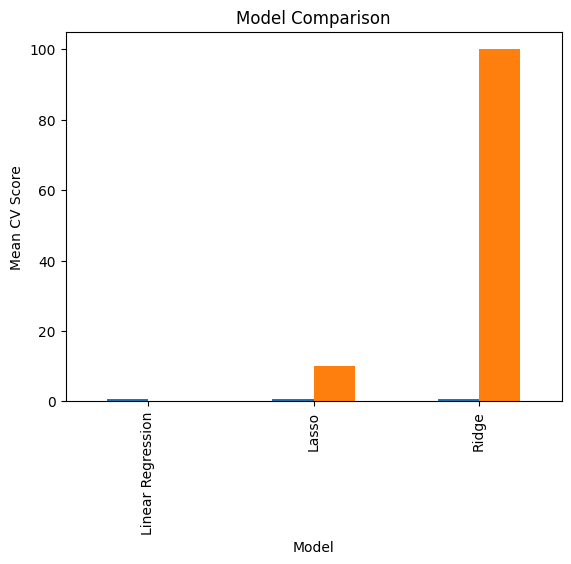

In [12]:
# Optional: Visualize results
results_df.set_index('Model').plot(kind='bar', legend=False)
plt.ylabel('Mean CV Score')
plt.title('Model Comparison')
plt.show()